#Data Preparation:
- Link dataset: https://www.kaggle.com/competitions/titanic
- Usar one-hot-encoding para codificar features categóricas
- Usar normalização/padronização nas features numericas
Modeling: (verificar por coluna)
- Usar uma árvore de decisão
- Usar um método de bagging de árvore (ex: Random Forest)
- Usar modelos para prever a sobrevivência dos passageiros (probabilidade e classe)
Evaluation:
- K-Fold Cross-Validation
- Usar métricas Precision, Recall, e F1-Score
- (Opcional) Verificar calibração do modelos (usando reliability diagrams » https://towardsdatascience.com/introduction-to-reliability-diagrams-for-probability-calibration-ed785b3f5d44)

https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

In [ ]:
#!pip install kaggle

In [ ]:
#!pip3 uninstall statsmodels

In [ ]:
#!pip3 install numpy scipy patsy pandas

In [ ]:
#!pip3 install statsmodels

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from sklearn.calibration import calibration_curve

##Features

*   **survival**: Survival 0 = No, 1 = Yes
*   **pclass**: Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
*   **sex:**	Sex	
*   **Age**: in years	
*   **sibsp:**	# of siblings / spouses aboard the Titanic	
*   **parch:**	# of parents / children aboard the Titanic	
*   **ticket:**	Ticket number	
*   **fare:**	Passenger fare	
*   **cabin:**	Cabin number	
*   **embarked:**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton



##Carregar Dados

In [2]:
titanic_raw_train = pd.read_csv('train.csv')
titanic_raw_test = pd.read_csv('test.csv')

In [3]:
titanic_raw_train = titanic_raw_train.drop(columns=['PassengerId'])
titanic_raw_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Exploration

In [4]:
titanic_raw_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic_raw_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Visualização dos dados

In [6]:
n_cols = 3
n_rows = (titanic_raw_train.shape[1] // n_cols) + 1

In [7]:
columns_to_plot = titanic_raw_train.drop(columns= ['Name', 'Ticket', 'Cabin'])

fig = make_subplots(rows=n_rows, cols=n_cols)

for i, column_name in enumerate(columns_to_plot.columns):
    row = (i // n_cols) + 1
    col = (i % n_cols) + 1

    fig.add_trace(
        go.Histogram(x=columns_to_plot[column_name]),
        row=row, col=col
    )

    fig.update_xaxes(title_standoff=10, title_text=column_name, row=row, col=col)
    fig.update_yaxes(title_text='', row=row, col=col)

fig.update_layout(
    title='Data distribuition',
    bargap=0.1,
    showlegend=False
)

fig.show()


###Tratamento de valores faltantes

In [8]:
titanic_raw_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [9]:
titanic_raw_train.isna().describe()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,891,891,891,891,891,891,891,891
unique,1,1,1,1,2,1,1,1,1,2,2
top,False,False,False,False,False,False,False,False,False,True,False
freq,891,891,891,891,714,891,891,891,891,687,889


In [10]:
titanic_raw_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [11]:
titanic_raw_test.isna().describe()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418,418,418,418,418,418,418,418,418,418,418
unique,1,1,1,1,2,1,1,1,2,2,1
top,False,False,False,False,False,False,False,False,False,True,False
freq,418,418,418,418,332,418,418,418,417,327,418


In [12]:
# Registros onde Embarked é nulo
titanic_raw_train.loc[pd.isnull(titanic_raw_train['Embarked'])]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [13]:
# Verificando se um ticket se repete 
# Quero saber se pessoas com o mesmo tickect sobrevivem 
# Nova coluna chamada possui mesmo ticket 0 ou 1
titanic_raw_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [14]:
# Apagar linhas com coluna Embarked nula
line_index_null = titanic_raw_train.loc[pd.isnull(titanic_raw_train['Embarked'])].index
titanic_train = titanic_raw_train.drop(line_index_null)

# Remove Coluna Cabin, pois os valores nulos é em maior número
titanic_train = titanic_train.drop(['Cabin', 'Name', 'Ticket'], axis =1)
titanic_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [15]:
# Dados de teste
#titanic_test = titanic_raw_test.drop(columns=['Cabin', 'Name', 'Ticket'])
titanic_test = titanic_raw_test.drop(['Cabin', 'Name', 'Ticket'], axis =1)

In [16]:
titanic_test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

####Valores faltantes para Age

Algumas técnicas podem ser utilizadas para verificar se uma feature tem distribuição normal.
https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0

Tipos de preenchimento: https://towardsdatascience.com/how-to-fill-missing-data-with-pandas-8cb875362a0d

*   Histogramas
*   Box plot
*   Gráfico QQ



In [ ]:
# np.unique(titanic_raw_train['Age'])

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  ,
       48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ,   nan])

In [17]:
np.unique(titanic_train['Age'])

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  ,
       48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ,   nan])

In [18]:
np.unique(titanic_test['Age'])

array([ 0.17,  0.33,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  5.  ,
        6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.5 , 12.  , 13.  , 14.  ,
       14.5 , 15.  , 16.  , 17.  , 18.  , 18.5 , 19.  , 20.  , 21.  ,
       22.  , 22.5 , 23.  , 24.  , 25.  , 26.  , 26.5 , 27.  , 28.  ,
       28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 ,
       35.  , 36.  , 36.5 , 37.  , 38.  , 38.5 , 39.  , 40.  , 40.5 ,
       41.  , 42.  , 43.  , 44.  , 45.  , 46.  , 47.  , 48.  , 49.  ,
       50.  , 51.  , 53.  , 54.  , 55.  , 57.  , 58.  , 59.  , 60.  ,
       60.5 , 61.  , 62.  , 63.  , 64.  , 67.  , 76.  ,   nan])

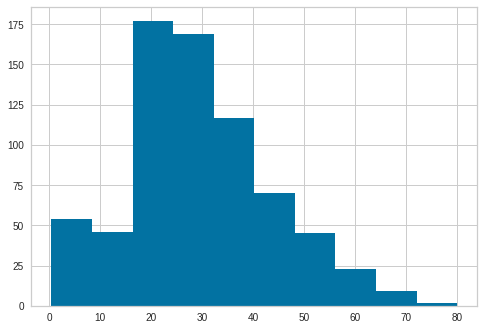

In [19]:
# Histograma
# hist_age = pd.Series(titanic_raw_train['Age'])
hist_age = pd.Series(titanic_train['Age'])
hist_age.hist();

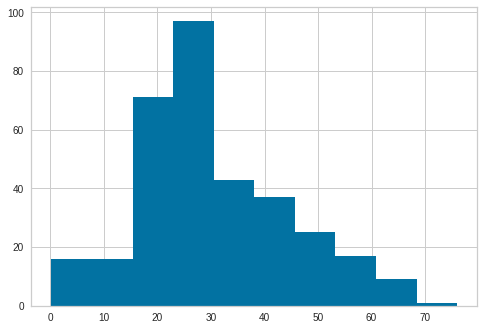

In [20]:
hist_age_test = pd.Series(titanic_test['Age'])
hist_age_test.hist()

In [21]:
# Box plot
# Normal "perfeito" não pode ter outliers, e cada divisão de ser simetricas
# Não é muito bom para verificar se é normal

fig = px.box(titanic_train['Age'])
fig.update_layout(
    width=500,
    height=500
)
fig.show()

In [26]:
fig = px.box(titanic_test['Age'])
fig.update_layout(
    width=500,
    height=500
)
fig.show()

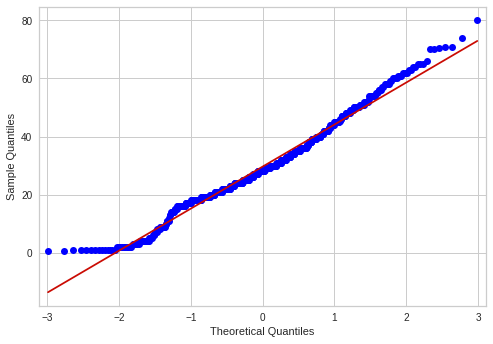

In [27]:
# Gráfico QQ
import statsmodels.api as sm
from scipy.stats import norm
import pylab

notnull_age = titanic_train[titanic_train['Age'].notnull()]
sm.qqplot(notnull_age['Age'], line='s')
pylab.show()

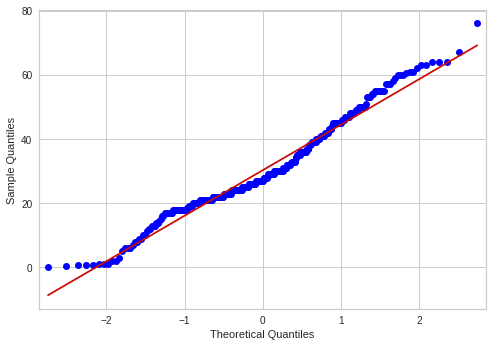

In [28]:
notnull_age_test = titanic_test[titanic_test['Age'].notnull()]
sm.qqplot(notnull_age_test['Age'], line='s')
pylab.show()

In [29]:
from pandas.core.common import random_state
# Shapiro
from scipy.stats import norm
from scipy.stats import shapiro

notnull_age = titanic_train[titanic_train['Age'].notnull()]
stat, p = shapiro(notnull_age['Age'])

alpha = 0.05
if p > alpha:
    print('É normal. Não rejeita hipotese nula')
else:
    print('Não é normal. Rejeita hipotese nula')


Não é normal. Rejeita hipotese nula


In [30]:
# Preenchendo os valores nulos com a média das idades
titanic_train['Age'].fillna(titanic_train['Age'].mean(), inplace = True)

In [31]:
# Preenchendo os valores nulos com a média das idades (Dados de teste)
titanic_test['Age'].fillna(titanic_test['Age'].mean(), inplace=True)

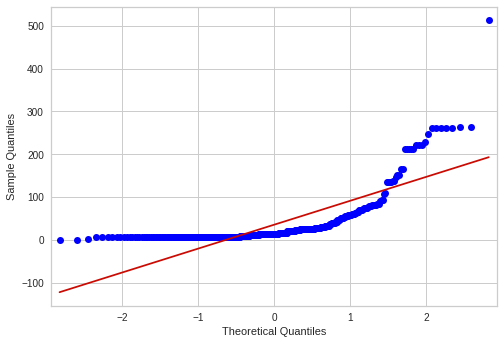

In [32]:
notnull_age_test = titanic_test[titanic_test['Fare'].notnull()]
sm.qqplot(notnull_age_test['Fare'], line='s')
pylab.show()

In [33]:
# A regra é clara. Se não souber o que fazer, coloca mediana
# Como os dados não estão em uma distribuição normal. Preenchemos com a mediana
titanic_test['Fare'].fillna(titanic_test['Fare'].median(), inplace=True)

In [36]:
titanic_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [45]:
titanic_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.642093,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


In [38]:
titanic_test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [39]:
titanic_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.50000,0,0,7.8292,Q
1,893,3,female,47.00000,1,0,7.0000,S
2,894,2,male,62.00000,0,0,9.6875,Q
3,895,3,male,27.00000,0,0,8.6625,S
4,896,3,female,22.00000,1,1,12.2875,S
...,...,...,...,...,...,...,...,...
413,1305,3,male,30.27259,0,0,8.0500,S
414,1306,1,female,39.00000,0,0,108.9000,C
415,1307,3,male,38.50000,0,0,7.2500,S
416,1308,3,male,30.27259,0,0,8.0500,S


#Continuação Utilizando numpy array

### Divisão entre previsores e classe

In [40]:
type(titanic_train)

pandas.core.frame.DataFrame

In [41]:
titanic_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [42]:
# Seleciona colunas
# X_titanic = titanic_train.drop(columns=['PassengerId', 'Survived']).values
X_titanic = titanic_train.iloc[:, 2:].values
X_titanic # numpy array

array([['male', 22.0, 1, 0, 7.25, 'S'],
       ['female', 38.0, 1, 0, 71.2833, 'C'],
       ['female', 26.0, 0, 0, 7.925, 'S'],
       ...,
       ['female', 29.64209269662921, 1, 2, 23.45, 'S'],
       ['male', 26.0, 0, 0, 30.0, 'C'],
       ['male', 32.0, 0, 0, 7.75, 'Q']], dtype=object)

In [43]:
X_titanic[0]

array(['male', 22.0, 1, 0, 7.25, 'S'], dtype=object)

In [46]:
y_titanic = titanic_train.iloc[:,0]
y_titanic

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

####Dados de teste

In [ ]:
titanic_test.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [ ]:
X_titanic_teste = titanic_test.iloc[: , 1:].values
X_titanic_teste

array([[3, 'male', 34.5, ..., 0, 7.8292, 'Q'],
       [3, 'female', 47.0, ..., 0, 7.0, 'S'],
       [2, 'male', 62.0, ..., 0, 9.6875, 'Q'],
       ...,
       [3, 'male', 38.5, ..., 0, 7.25, 'S'],
       [3, 'male', 30.272590361445783, ..., 0, 8.05, 'S'],
       [3, 'male', 30.272590361445783, ..., 1, 22.3583, 'C']],
      dtype=object)

In [ ]:
X_titanic_teste[0]

array([3, 'male', 34.5, 0, 0, 7.8292, 'Q'], dtype=object)

###Tratamento de atributos categóricos

####Label encoder

##### Dataset de treino

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder_sex = LabelEncoder()
label_encoder_embarked = LabelEncoder()

In [ ]:
X_titanic[:, 1] = label_encoder_sex.fit_transform(X_titanic[:, 1])
X_titanic[:, 6] = label_encoder_embarked.fit_transform(X_titanic[:, 6])

In [ ]:
X_titanic[0]

array([3, 1, 22.0, 1, 0, 7.25, 2], dtype=object)

#####Dataset de teste

In [ ]:
label_encoder_sex_test = LabelEncoder()
label_encoder_embarked_test = LabelEncoder()

In [ ]:
X_titanic_teste[: , 1] = label_encoder_sex_test.fit_transform(X_titanic_teste[:, 1])
X_titanic_teste[: , 6] = label_encoder_sex_test.fit_transform(X_titanic_teste[:, 6])

In [ ]:
X_titanic_teste[0]

array([3, 1, 34.5, 0, 0, 7.8292, 1], dtype=object)

#### One Hot Encoder

#####Dataset de treino

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
# passthrough é utilizado para não apagar os outros atributos
# Tentar não utilizar ColumnTransformer. 

onehotencoder_titanic = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1,6])], remainder='passthrough')

In [ ]:
X_titanic = onehotencoder_titanic.fit_transform(X_titanic)

In [ ]:
X_titanic

array([[0.0, 1.0, 0.0, ..., 1, 0, 7.25],
       [1.0, 0.0, 1.0, ..., 1, 0, 71.2833],
       [1.0, 0.0, 0.0, ..., 0, 0, 7.925],
       ...,
       [1.0, 0.0, 0.0, ..., 1, 2, 23.45],
       [0.0, 1.0, 1.0, ..., 0, 0, 30.0],
       [0.0, 1.0, 0.0, ..., 0, 0, 7.75]], dtype=object)

In [ ]:
X_titanic.shape

(889, 10)

#####Dataset de teste

In [ ]:
onehotencoder_titanic_teste = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1,6])], remainder='passthrough')

In [ ]:
X_titanic_teste = onehotencoder_titanic_teste.fit_transform(X_titanic_teste)

In [ ]:
X_titanic_teste

array([[0.0, 1.0, 0.0, ..., 0, 0, 7.8292],
       [1.0, 0.0, 0.0, ..., 1, 0, 7.0],
       [0.0, 1.0, 0.0, ..., 0, 0, 9.6875],
       ...,
       [0.0, 1.0, 0.0, ..., 0, 0, 7.25],
       [0.0, 1.0, 0.0, ..., 0, 0, 8.05],
       [0.0, 1.0, 1.0, ..., 1, 1, 22.3583]], dtype=object)

####Escalonamento de Valores

Se a distribuição da quantidade for normal, ela deve ser padronizada (standardized), caso contrário, os dados devem ser normalizados (normalized)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_titanic = StandardScaler()

#####Dataset de treino

In [ ]:
X_titanic = scaler_titanic.fit_transform(X_titanic)

In [ ]:
X_titanic[0]

array([-0.73534203,  0.73534203, -0.48271079, -0.30794088,  0.61679395,
        0.82520863, -0.58961986,  0.43135024, -0.47432585, -0.50023975])

#####Dataset de teste

In [ ]:
X_titanic_teste = scaler_titanic.fit_transform(X_titanic_teste)

In [ ]:
X_titanic_teste[0]

array([-0.75592895,  0.75592895, -0.56814154,  2.84375747, -1.35067551,
        0.87348191,  0.3349926 , -0.49947002, -0.4002477 , -0.49840706])

###Divisão em treino e teste

X_titanic e y_titanic são os dados de treino sem divisão

X_titanic_train, X_titanic_test_split, y_titanic_train, y_titanic_test_split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_titanic_train, X_titanic_test_split, y_titanic_train, y_titanic_test_split = train_test_split(X_titanic, y_titanic, test_size=0.30, random_state=1001);

In [ ]:
X_titanic_train.shape, y_titanic_train.shape

((622, 10), (622,))

###Salvar as cariáveis

In [ ]:
import pickle

In [ ]:
with open('titanic.pkl', mode='wb') as f:
    pickle.dump([X_titanic_train, y_titanic_train, X_titanic_test_split, y_titanic_test_split], f)

##Modelagem

In [ ]:
from sklearn.model_selection import GridSearchCV

###Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
parametros = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10],
              'random_state': [1001]}

In [ ]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parametros)
grid_search.fit(X_titanic_train, y_titanic_train)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 1001, 'splitter': 'random'}
0.8150967741935483


In [ ]:
arvore_titanic = DecisionTreeClassifier(criterion='entropy', min_samples_leaf= 1, min_samples_split= 10, random_state=1001, splitter='random')
arvore_titanic.fit(X_titanic_train, y_titanic_train)

TypeError: ignored

In [ ]:
melhores_parametros

{'activation': 'relu', 'batch_size': 10, 'solver': 'sgd'}

In [ ]:
previsoes = arvore_titanic.predict(X_titanic_test_split)
previsoes

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1])

In [ ]:
y_titanic_test_split

855    1
82     1
713    0
134    0
700    1
      ..
741    0
810    0
192    1
373    0
618    1
Name: Survived, Length: 267, dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
accuracy_score(y_titanic_test_split, previsoes)

0.8052434456928839

0.8052434456928839

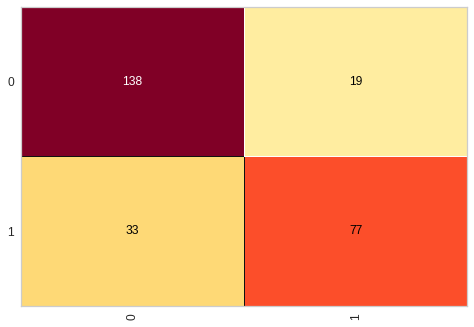

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(arvore_titanic)
cm.fit(X_titanic_train, y_titanic_train)
cm.score(X_titanic_test_split, y_titanic_test_split)

###Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 35, 40, 100, 150],
              'min_samples_split': [2, 4, 5, 6, 10],
              'min_samples_leaf': [1, 5, 10],
              'random_state': [1001]
              }

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X_titanic_train, y_titanic_train)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 40, 'random_state': 1001}
0.8376258064516129


In [ ]:
random_forest_titanic = RandomForestClassifier(n_estimators=40, criterion='gini', min_samples_leaf=1, min_samples_split=4, random_state = 1001)
random_forest_titanic.fit(X_titanic_train, y_titanic_train)

RandomForestClassifier(min_samples_split=4, n_estimators=40, random_state=1001)

In [ ]:
previsoes_RF = random_forest_titanic.predict(X_titanic_test_split)
previsoes_RF

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_titanic_test_split, previsoes_RF)

0.8202247191011236

0.8202247191011236

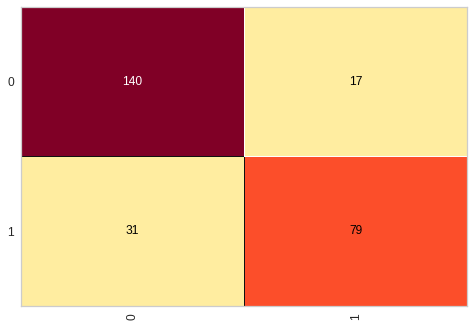

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(random_forest_titanic)
cm.fit(X_titanic_train, y_titanic_train)
cm.score(X_titanic_test_split, y_titanic_test_split)

###SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_titanic =  SVC(kernel='rbf', C=2.0)
svm_titanic.fit(X_titanic_train, y_titanic_train)

SVC(C=2.0)

In [ ]:
previsoes_SVM = svm_titanic.predict(X_titanic_test_split)
previsoes_SVM

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1])

In [ ]:
accuracy_score(y_titanic_test_split, previsoes_SVM)

0.8089887640449438

0.8089887640449438

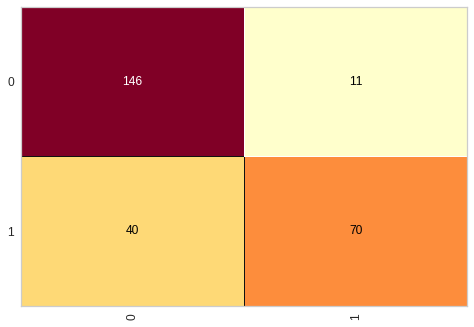

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(svm_titanic)
cm.fit(X_titanic_train, y_titanic_train)
cm.score(X_titanic_test_split, y_titanic_test_split)

###Rede neural

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
parametros = {'activation': ['relu', 'logistic', 'tahn'],
              'solver': ['adam', 'sgd'],
              'batch_size': [10, 56]}

In [ ]:
grid_search = GridSearchCV(estimator=MLPClassifier(), param_grid=parametros)
grid_search.fit(X_titanic_train, y_titanic_train)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

In [ ]:
# rede_neural = MLPClassifier(**melhores_parametros); # TOP
rede_neural = MLPClassifier(activation = 'relu', batch_size = 56, solver = 'adam');

In [ ]:
rede_neural.fit(X_titanic_train, y_titanic_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(batch_size=56)

In [ ]:
previsoes_rede_neural = rede_neural.predict(X_titanic_test_split)
previsoes_rede_neural

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1])

In [ ]:
accuracy_score(y_titanic_test_split, previsoes_rede_neural)

0.7902621722846442

0.7902621722846442

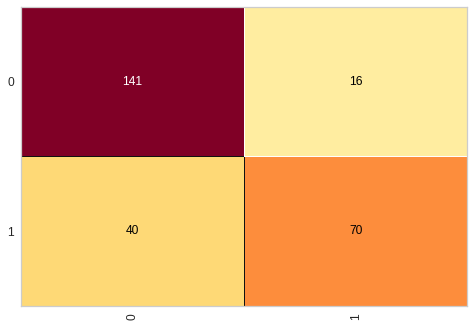

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(rede_neural)
cm.fit(X_titanic_train, y_titanic_train)
cm.score(X_titanic_test_split, y_titanic_test_split)

##Validação

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
resultados_decission_tree = []
resultados_random_forest = []
resultados_svm = []
resultados_mlp = []

# KFold ou StratifiedKFold (Dataset Desbalanceado)
kfold = KFold(n_splits=5, shuffle=True, random_state=1001)

arvore_titanic = DecisionTreeClassifier(criterion='entropy', min_samples_leaf= 1, min_samples_split= 10, random_state=1001, splitter='random')
scores_DT = cross_val_score(arvore_titanic, X_titanic_train, y_titanic_train, cv=kfold)
resultados_decission_tree.append(scores_DT.mean())

random_forest_titanic = RandomForestClassifier(n_estimators=40, criterion='gini', min_samples_leaf=1, min_samples_split=4, random_state = 1001)
scores_RF = cross_val_score(random_forest_titanic, X_titanic_train, y_titanic_train, cv=kfold)
resultados_random_forest.append(scores_RF.mean())

svm_titanic =  SVC(kernel='rbf', C=2.0)
scores_SVM = cross_val_score(svm_titanic, X_titanic_train, y_titanic_train, cv = kfold)
resultados_svm.append(scores_SVM)

rede_neural = MLPClassifier(activation = 'relu', batch_size = 56, solver = 'adam');
scores_mlp = cross_val_score(rede_neural, X_titanic_train, y_titanic_train, cv = kfold)
resultados_mlp.append(scores_mlp)

# random_forest_titanic.fit(X_titanic_train, y_titanic_train)
print(resultados_decission_tree)
print(resultados_random_forest)
print(resultados_svm)
print(resultados_mlp)

In [ ]:
resultados_random_forest

[0.8301720307243065]

In [ ]:
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef

In [ ]:
print(metrics.classification_report(y_titanic_test, previsoes_RF, digits=3))

              precision    recall  f1-score   support

           0      0.833     0.892     0.862       157
           1      0.828     0.745     0.785       110

    accuracy                          0.831       267
   macro avg      0.831     0.819     0.823       267
weighted avg      0.831     0.831     0.830       267



In [ ]:
#      Treino          Teste
# Treino validação     Teste
#      Treino          Teste  -. Após escolher o melhor modelo

In [ ]:
random_forest_titanic = RandomForestClassifier(n_estimators=35, criterion='entropy', min_samples_leaf=1, min_samples_split=5, random_state = 0)
random_forest_titanic.fit(X_titanic_train, y_titanic_train)
RF_predicts = random_forest_titanic.predict(X_titanic_test_split)

In [ ]:
 print(metrics.classification_report(y_titanic_test_split, RF_predicts, digits=3))

              precision    recall  f1-score   support

           0      0.834     0.898     0.865       157
           1      0.837     0.745     0.788       110

    accuracy                          0.835       267
   macro avg      0.836     0.822     0.827       267
weighted avg      0.835     0.835     0.833       267



In [ ]:
rede_neural_final = MLPClassifier(max_iter=5000, verbose=True, tol=0.00001, activation = 'relu', solver='adam', hidden_layer_sizes=(16, 8, 8), random_state=101);
rede_neural_final.fit(X_titanic, y_titanic);
RN_predicts = rede_neural_final.predict(X_titanic_test_split)

In [ ]:
print(metrics.classification_report(y_titanic_test_split, RN_predicts, digits=3))

              precision    recall  f1-score   support

           0      0.859     0.930     0.893       157
           1      0.887     0.782     0.831       110

    accuracy                          0.869       267
   macro avg      0.873     0.856     0.862       267
weighted avg      0.870     0.869     0.867       267



##Avaliação Final

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_titanic.shape

(889, 10)

In [ ]:
random_forest_titanic = RandomForestClassifier(n_estimators=35, criterion='entropy', min_samples_leaf=1, min_samples_split=5, random_state = 0)
random_forest_titanic.fit(X_titanic, y_titanic)
RF_predicts = random_forest_titanic.predict(X_titanic_teste)

In [ ]:
rede_neural_final = MLPClassifier(max_iter=1500, verbose=True, tol=0.00001, shuffle=True, activation = 'relu', solver = 'adam', hidden_layer_sizes=(6, 6));
rede_neural_final.fit(X_titanic, y_titanic);
RN_predicts = rede_neural_final.predict(X_titanic_teste)

In [ ]:
RF_predicts

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
print(metrics.classification_report(y_titanic_test, RF_predicts, digits=3))

In [ ]:
RN_predicts

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

##Exportando resultados

In [ ]:
# Random Forest
submission = pd.DataFrame({
    "PassengerId": titanic_test["PassengerId"],
    "Survived": RF_predicts
})
submission.to_csv('submission.csv', index=False, encoding='utf-8')

In [ ]:
submission = pd.DataFrame({
    "PassengerId": titanic_test["PassengerId"],
    "Survived": RN_predicts
})
submission.to_csv('submission_RN.csv', index=False, encoding='utf-8')

# Continuação utilizando DataFrame

##Tratamento dos Atributos categóricos

In [47]:
from sklearn.preprocessing import OneHotEncoder

In [48]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [49]:
categorical_cols = titanic_train.dtypes[(titanic_train.dtypes != 'int64') & 
                                 (titanic_train.dtypes != 'float64')].index

In [50]:
categorical_cols

Index(['Sex', 'Embarked'], dtype='object')

In [51]:
ohe_df = enc.fit_transform(titanic_train[categorical_cols])
ohe_df = pd.DataFrame(ohe_df)

In [52]:
ohe_df

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...
884,0.0,1.0,0.0,0.0,1.0
885,1.0,0.0,0.0,0.0,1.0
886,1.0,0.0,0.0,0.0,1.0
887,0.0,1.0,1.0,0.0,0.0


In [53]:
titanic_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.642093,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


In [54]:
ohe_df = pd.concat([titanic_train.drop(columns=categorical_cols).reset_index(drop=True), ohe_df], axis=1)

# Se Fosse necessário altera para label encoder
# ohe_df['Survived'] = ohe_df['Survived'].replace({'N': 0, 'Y': 1})

In [55]:
ohe_df

,Survived,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4
0,0,3,22.000000,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.000000,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.000000,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.000000,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.000000,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,27.000000,0,0,13.0000,0.0,1.0,0.0,0.0,1.0
885,1,1,19.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0
886,0,3,29.642093,1,2,23.4500,1.0,0.0,0.0,0.0,1.0
887,1,1,26.000000,0,0,30.0000,0.0,1.0,1.0,0.0,0.0


##Divisão em treino e validação

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(ohe_df.drop(columns=['Survived']),
                                                    ohe_df['Survived'],
                                                    test_size=0.3,
                                                    random_state=0)

In [57]:
X_train, y_train

(     Pclass        Age  SibSp  Parch     Fare    0    1    2    3    4
 350       1  29.642093      0      0  35.0000  0.0  1.0  0.0  0.0  1.0
 124       3  12.000000      1      0  11.2417  0.0  1.0  1.0  0.0  0.0
 577       3  29.642093      1      0  14.4583  1.0  0.0  1.0  0.0  0.0
 422       3  28.000000      1      1  14.4000  1.0  0.0  0.0  0.0  1.0
 118       3   2.000000      4      2  31.2750  1.0  0.0  0.0  0.0  1.0
 ..      ...        ...    ...    ...      ...  ...  ...  ...  ...  ...
 835       3  29.642093      0      0   8.0500  0.0  1.0  0.0  0.0  1.0
 192       2   3.000000      1      1  26.0000  0.0  1.0  0.0  0.0  1.0
 629       1  80.000000      0      0  30.0000  0.0  1.0  0.0  0.0  1.0
 559       3  29.642093      0      0   7.7500  0.0  1.0  0.0  1.0  0.0
 684       2  25.000000      1      2  41.5792  0.0  1.0  1.0  0.0  0.0
 
 [622 rows x 10 columns], 350    0
 124    1
 577    0
 422    0
 118    0
       ..
 835    0
 192    1
 629    1
 559    0
 684    0

In [58]:
train_titanic_df = pd.concat([X_train, y_train], axis=1)
valid_titanic_df = pd.concat([X_valid, y_valid], axis=1)

##Escalonamento de Valores

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
train_scaler = StandardScaler()
valid_scaler = StandardScaler()

train_titanic_df[train_titanic_df.drop(columns=['Survived']).columns] = train_scaler.fit_transform(train_titanic_df.drop(columns=['Survived']))
valid_titanic_df[valid_titanic_df.drop(columns=['Survived']).columns] = valid_scaler.fit_transform(valid_titanic_df.drop(columns=['Survived']))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [61]:
train_titanic_df

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4,Survived
350,-1.599952,0.002869,-0.474732,-0.455218,0.079807,-0.724230,0.724230,-0.486395,-0.311451,0.623212,0
124,0.824336,-1.324898,0.406711,-0.455218,-0.407365,-0.724230,0.724230,2.055940,-0.311451,-1.604591,1
577,0.824336,0.002869,0.406711,-0.455218,-0.341408,1.380776,-1.380776,2.055940,-0.311451,-1.604591,0
422,0.824336,-0.120717,0.406711,0.729492,-0.342603,1.380776,-1.380776,-0.486395,-0.311451,0.623212,0
118,0.824336,-2.077511,3.051041,1.914202,0.003425,1.380776,-1.380776,-0.486395,-0.311451,0.623212,0
...,...,...,...,...,...,...,...,...,...,...,...
835,0.824336,0.002869,-0.474732,-0.455218,-0.472812,-0.724230,0.724230,-0.486395,-0.311451,0.623212,0
192,-0.387808,-2.002250,0.406711,0.729492,-0.104741,-0.724230,0.724230,-0.486395,-0.311451,0.623212,1
629,-1.599952,3.792871,-0.474732,-0.455218,-0.022719,-0.724230,0.724230,-0.486395,-0.311451,0.623212,1
559,0.824336,0.002869,-0.474732,-0.455218,-0.478964,-0.724230,0.724230,-0.486395,3.210777,-1.604591,0


##Modelagem

###Árvore de Decisão

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
parametros = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10],
              'random_state': [1001]}

In [ ]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parametros);
dtb = grid_search.fit(train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived']);
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_

In [65]:
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'random_state': 1001, 'splitter': 'best'}
0.8183225806451613


In [66]:
arvore_titanic = DecisionTreeClassifier(**dtb.best_params_)
arvore_titanic.fit(train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived'])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



DecisionTreeClassifier(criterion='entropy', min_samples_split=10,
                       random_state=1001)

In [67]:
previsoes = arvore_titanic.predict(valid_titanic_df.drop(columns=['Survived']))
previsoes

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



0.7715355805243446

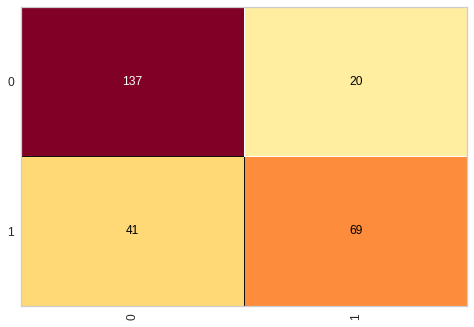

In [68]:
cm = ConfusionMatrix(arvore_titanic)
cm.fit(train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived'])
cm.score(valid_titanic_df.drop(columns=['Survived']), valid_titanic_df['Survived'])

###Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 35, 40, 100, 150],
              'min_samples_split': [2, 4, 5, 6, 10],
              'min_samples_leaf': [1, 5, 10],
              'random_state': [1001]
              }

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
rfb = grid_search.fit(train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived'])
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_

In [72]:
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10, 'random_state': 1001}
0.8360387096774193


In [73]:
random_forest_titanic = RandomForestClassifier(**rfb.best_params_)
random_forest_titanic.fit(train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived'])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



RandomForestClassifier(min_samples_split=10, n_estimators=10, random_state=1001)

In [74]:
previsoes_RF = random_forest_titanic.predict(valid_titanic_df.drop(columns=['Survived']))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



0.7715355805243446

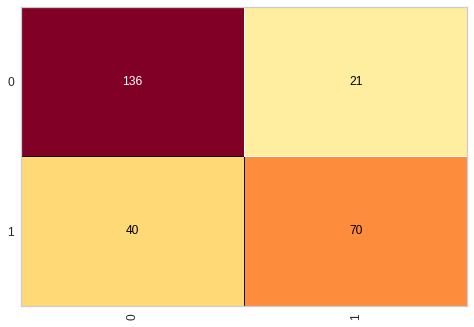

In [75]:
cm = ConfusionMatrix(random_forest_titanic)
cm.fit(train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived'])
cm.score(valid_titanic_df.drop(columns=['Survived']), valid_titanic_df['Survived'])

##Avaliação

In [ ]:
resultados_decission_tree = []
resultados_random_forest = []

skfold = StratifiedKFold(n_splits=5)

arvore_titanic = DecisionTreeClassifier(**dtb.best_params_)
scores_DT = cross_val_score(arvore_titanic, train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived'], cv=skfold)
resultados_decission_tree.append(scores_DT.mean())

random_forest_titanic = RandomForestClassifier(**rfb.best_params_)
scores_RF = cross_val_score(random_forest_titanic, train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived'], cv=skfold)
resultados_random_forest.append(scores_RF.mean())

In [77]:
print(resultados_decission_tree)
print(resultados_random_forest)

[0.8183225806451613]
[0.8360387096774193]


##Avaliação Final

In [78]:
complete_train_titanic = pd.concat([train_titanic_df, valid_titanic_df])
complete_train_titanic

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4,Survived
350,-1.599952,0.002869,-0.474732,-0.455218,0.079807,-0.724230,0.724230,-0.486395,-0.311451,0.623212,0
124,0.824336,-1.324898,0.406711,-0.455218,-0.407365,-0.724230,0.724230,2.055940,-0.311451,-1.604591,1
577,0.824336,0.002869,0.406711,-0.455218,-0.341408,1.380776,-1.380776,2.055940,-0.311451,-1.604591,0
422,0.824336,-0.120717,0.406711,0.729492,-0.342603,1.380776,-1.380776,-0.486395,-0.311451,0.623212,0
118,0.824336,-2.077511,3.051041,1.914202,0.003425,1.380776,-1.380776,-0.486395,-0.311451,0.623212,0
...,...,...,...,...,...,...,...,...,...,...,...
619,0.827849,-0.224445,0.496754,-0.532391,-0.386275,-0.761500,0.761500,2.109260,-0.299660,-1.661494,0
820,0.827849,-0.224445,-0.478491,-0.532391,-0.498439,-0.761500,0.761500,-0.474100,-0.299660,0.601868,1
64,0.827849,-0.007299,0.496754,0.875018,-0.370945,-0.761500,0.761500,2.109260,-0.299660,-1.661494,1
882,0.827849,-0.388820,-0.478491,-0.532391,-0.529667,-0.761500,0.761500,-0.474100,-0.299660,0.601868,0


In [79]:
complete_train_titanic.isna().describe()

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4,Survived
count,889,889,889,889,889,889,889,889,889,889,889
unique,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False
freq,889,889,889,889,889,889,889,889,889,889,889


In [80]:
random_forest_titanic = RandomForestClassifier(**rfb.best_params_)
random_forest_titanic.fit(train_titanic_df.drop(columns=['Survived']), train_titanic_df['Survived'])
#random_forest_titanic.fit(complete_train_titanic.drop(columns=["Survived"]), complete_train_titanic["complete_train_titanic"])
RF_predicts = random_forest_titanic.predict(valid_titanic_df.drop(columns=['Survived']))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



##Reliability diagrams

In [81]:
prob_true, prob_pred = calibration_curve(valid_titanic_df['Survived'], RF_predicts, n_bins=3)

In [82]:
print(prob_true)
print(prob_pred)

[0.22727273 0.76923077]
[0. 1.]


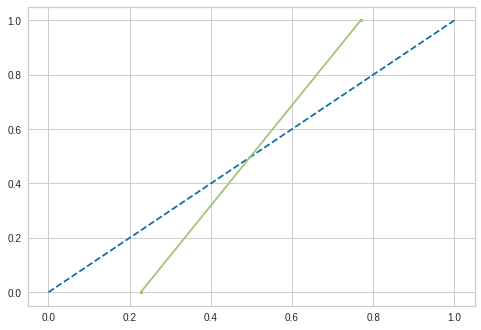

In [83]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_true, prob_pred, marker='.')
plt.show()